In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, romberg
from scipy.integrate import solve_ivp

In [3]:
# The differential equation
def dedomega(F, e):
    return -(e * (1 - e**2) * (304 + 121 * e**2)) / (
        3 * F * (96 + 292 * e**2 + 37 * e**4)
    )

# PySR symbolic regression
def regressionhigh(F, e0):
    e = 0.9790411256863631*(1/(F/(10*e0) - (F/10)**1.012737893610754 + 1.4302123798377845*(1/((F/10)/(e0 - 0.22142359302825657) + (0.60174062522152904*(F/10)**(-F/10)*e0)**(F/10) + 0.860130507088693))**0.35782295061328334))**1.118891179324739
    return e

# The IVP solver
def integrate(F, e0):
    if F > c**3 / (6 ** (3 / 2) * np.pi * G * m) or F < 10:
        return 0
    sol = solve_ivp(
        dedomega,
        [10, c**3 / (6 ** (3 / 2) * np.pi * G * m)],
        [e0],
        t_eval=[F],
    )
    return sol.y[0][0]

# Leading order Taylor expansion
def expansion(F, e0):
    chi = F/10
    e = e0*chi**(-19/18) + 3323/1824 * e0**3*(chi**(-19/18) - chi**(-19/6)) + e0**5 * (15994231/6653952*chi**(-19/18) - 11042329/1108992*chi**(-19/6) + 50259743/6653952*chi**(-95/18))
    return e

In [4]:
# All the equations to calculate tau and psi_j for the integral
def tauint(F, f, e0):
    e = integrate(f, e0)
    Fdot = 1/(2*np.pi) * (G*m*2*np.pi*f)**(5/3)*(2*np.pi*f)**2*eta/(5*c**5*(1-e**2)**(7/2)) * (96 + 292*e**2 + 37*e**4)
    return F / Fdot

def integrandint(F, f, e0):
    return tauint(F, f, e0) * (2 - f / F)

def psiint(f, e0):
    psi, _ = quad(integrandint, 10, f/2, args=(f, e0))
    return 2*np.pi*psi

# All the equations to calculate tau and psi_j for the PySR regression
def taureg(F, f, e0):
    e = regressionhigh(f, e0)
    Fdot = 1/(2*np.pi) * (G*m*2*np.pi*f)**(5/3)*(2*np.pi*f)**2*eta/(5*c**5*(1-e**2)**(7/2)) * (96 + 292*e**2 + 37*e**4)
    return F / Fdot

def integrandreg(F, f, e0):
    return taureg(F, f, e0) * (2 - f / F)

def psireg(f, e0):
    psi, _ = quad(integrandreg, 10, f/2, args=(f, e0))
    return 2*np.pi*psi

# All the equations to calculate tau and psi_j for the Taylor expansion
def tautay(F, f, e0):
    e = expansion(f, e0)
    Fdot = 1/(2*np.pi) * (G*m*2*np.pi*f)**(5/3)*(2*np.pi*f)**2*eta/(5*c**5*(1-e**2)**(7/2)) * (96 + 292*e**2 + 37*e**4)
    return F / Fdot

def integrandtay(F, f, e0):
    return tautay(F, f, e0) * (2 - f / F)

def psitay(f, e0):
    psi, _ = quad(integrandtay, 10, f/2, args=(f, e0))
    return 2*np.pi*psi

# Analytical approximation of psi_j
def psij(f, e0):
    return -3/(128*eta)*(G*m*np.pi*f/c**3)**(-5/3)*(1-2355*e0**2/1462*(f/10)**(-19/9))

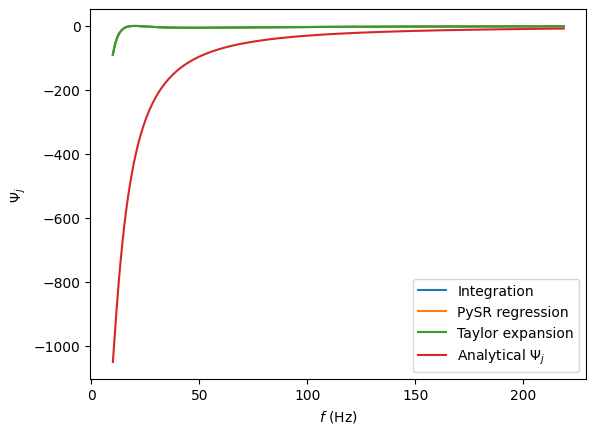

In [6]:
G = 6.67e-11
m = 20 * 2e30
eta = (0.5*m * 0.5*m)/(m**2)
c = 299792458

ISCO = c**3 / (6 ** (3 / 2) * np.pi * G * m)

fs = np.linspace(10, ISCO, 1000)
psiregl, psiintl, psitayl = [], [], []
for f in fs:
    psiregl.append(psireg(f, 0.4))
    psiintl.append(psiint(f, 0.4))
    psitayl.append(psitay(f, 0.4))

plt.plot(fs, psiintl, label="Integration")
plt.plot(fs, psiregl, label="PySR regression")
plt.plot(fs, psitayl, label="Taylor expansion")
plt.plot(fs, psij(fs, 0.4), label=r"Analytical $\Psi_j$")
plt.ylabel(r"$\Psi_j$")
plt.xlabel(r"$f$ (Hz)")
plt.legend()
plt.show()

In [5]:
# Calculating the strain for the regression, integration and Taylor expansion respectively.
def strainreg(f, e0):
    e = regressionhigh(f, e0)
    h = (G*m*np.pi*f/c**3)*((1-e**2)**(7/4)/(1+73/24*e**2 + 37/96*e**4)**(1/2))*np.exp(-1j*(np.pi/4 + psireg(f, e0)))
    return h

def strainint(f, e0):
    e = integrate(f, e0)
    h = (G*m*np.pi*f/c**3)*((1-e**2)**(7/4)/(1+73/24*e**2 + 37/96*e**4)**(1/2))*np.exp(-1j*(np.pi/4 + psiint(f, e0)))
    return h

def straintay(f, e0):
    e = expansion(f, e0)
    h = (G*m*np.pi*f/c**3)*((1-e**2)**(7/4)/(1+73/24*e**2 + 37/96*e**4)**(1/2))*np.exp(-1j*(np.pi/4 + psitay(f, e0)))
    return h

In [6]:
integration = {}
taylor = {}
regression = {}
for e0 in [0.3, 0.4, 0.5, 0.6, 0.7]:
    regression[e0], integration[e0], taylor[e0] = [], [], []
    for f in fs:
        regression[e0].append(strainreg(f, e0))
        integration[e0].append(strainint(f, e0))
        taylor[e0].append(straintay(f, e0))

In [8]:
import pycbc
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

df = (ISCO - 10) / 1000

intseries = {}
tayseries = {}
regseries = {}
for e0 in [0.3, 0.4, 0.5, 0.6, 0.7]:
    intseries[e0] = pycbc.types.frequencyseries.FrequencySeries(integration[e0], delta_f = df)
    tayseries[e0] = pycbc.types.frequencyseries.FrequencySeries(taylor[e0], delta_f = df)
    regseries[e0] = pycbc.types.frequencyseries.FrequencySeries(regression[e0], delta_f = df)

/home/aminrs/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


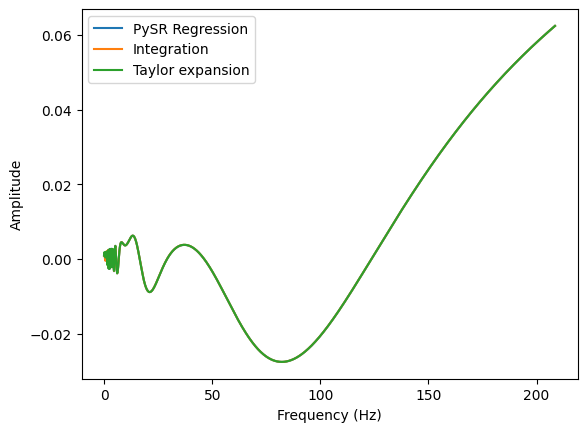

In [9]:
# Create the frequency axis
frequencies = np.arange(len(intseries[0.3])) * df

# Plot the amplitude spectrum
plt.plot(frequencies, regseries[0.4], label='PySR Regression')
plt.plot(frequencies, intseries[0.4], label="Integration")
plt.plot(frequencies, tayseries[0.4], label='Taylor expansion')
# plt.plot(frequencies, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [10]:
# Generate the aLIGO ZDHP PSD
flen = len(intseries[0.3])

f_low = 10
psd = aLIGOZeroDetHighPower(flen, df, f_low)

tay = []
new = []
for e0 in [0.3, 0.4, 0.5, 0.6, 0.7]:
    m1, i = match(intseries[e0], tayseries[e0], psd=psd, low_frequency_cutoff=f_low)
    m2, i = match(intseries[e0], regseries[e0], psd=psd, low_frequency_cutoff=f_low)
    tay.append(m1)
    new.append(m2)

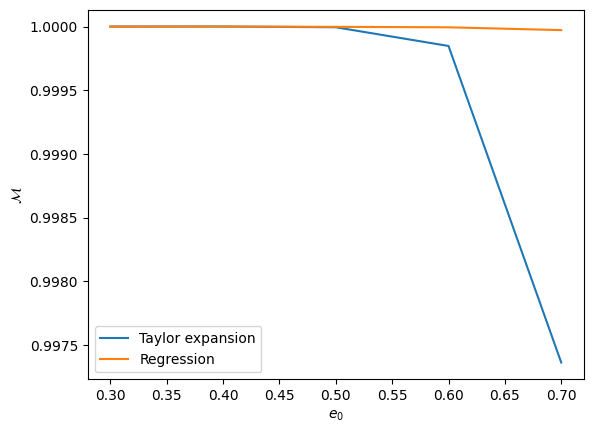

In [11]:
e0s = [0.3, 0.4, 0.5, 0.6, 0.7]
plt.plot(e0s, tay, label="Taylor expansion")
plt.plot(e0s, new, label="Regression")
plt.legend()
plt.ylabel(r"$\mathcal{M}$")
plt.xlabel(r"$e_0$")
plt.show()